## Codigo principal para el mecanismo de Pivot

In [3]:
import itertools
import numpy as np
import math
from typing import List, Tuple, Dict
from collections import defaultdict
import matplotlib.pyplot as plt
from mpmath import *

# Definición de tipos
Point = Tuple[float, float]
Trajectory = List[Point]

class PivotSampling:
    def __init__(self, epsilon: float = 5.0, 
                 D_candidates: List[int] = [2, 4, 6, 8, 12], R: float = 6371000.0): 
        self.epsilon_total = epsilon
        self.epsilon_dir = 0.75 * epsilon
        self.epsilon_ind = 0.125 * epsilon 
        self.epsilon_rest = 0.125 * epsilon 
        self.D_candidates = D_candidates
        self.R = R

        self.D_opt = self._select_optimal_granularity()
        
    def haversine_distance(self, p1: Point, p2: Point) -> float:
        """Distancia Haversine en metros"""
        lat1, lon1 = math.radians(p1[0]), math.radians(p1[1])
        lat2, lon2 = math.radians(p2[0]), math.radians(p2[1])
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        return self.R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))


    def _select_optimal_granularity(self) -> int:
        """
        Selecciona la granularidad óptima |D| según la Ecuación 8 del paper.
        Esta implementación es 100% fiel a la fórmula y explicación del paper.
        
        CLAVE: El paper evalúa el performance promedio considerando que
        CUALQUIER dirección puede ser la correcta, no solo d=0.
        """
        best_score = -1
        best_g = 2
        
        # D_c: conjunto de granularidades candidatas
        D_c = self.D_candidates
        
        # Θ = {θⱼ | θⱼ = π/g, g ∈ D_c}
        Theta = [math.pi / g for g in D_c]
        
        # Para cada granularidad candidata g
        for g in D_c:
            
            # R(g) = {0, 1, 2, ..., g-1}
            R_g = list(range(g))
            
            # Calcular score promedio considerando TODAS las posibles direcciones correctas
            # Esto es lo que hace el paper: evaluar el performance general del mecanismo
            total_score_all_directions = 0.0
            
            # Para cada posible dirección correcta d
            for d_correct in R_g:
                score_for_this_d = 0.0
                
                # Sumar sobre todos los θⱼ ∈ Θ
                for theta_j in Theta:
                    
                    # Sumar sobre todos los dᵢ ∈ R(g)
                    for d_i in R_g:
                        # φ(dᵢ; θⱼ): proporción de intersección
                        phi = self._calculate_phi(d_i, theta_j, g)
                        
                        # λ(dᵢ; ε; g): probabilidad k-RR con d_correct como dirección verdadera
                        lambda_val = self._calculate_lambda(d_i, d_correct, g)
                        
                        score_for_this_d += phi * lambda_val
                
                # Promedio sobre |Θ| para esta dirección correcta específica
                avg_score_for_this_d = score_for_this_d / len(Theta)
                total_score_all_directions += avg_score_for_this_d
            
            # Promedio sobre todas las posibles direcciones correctas
            # Esto representa el performance esperado del mecanismo en general
            overall_avg_score = total_score_all_directions / len(R_g)
            
            if overall_avg_score > best_score:
                best_score = overall_avg_score
                best_g = g
        
        return best_g

    def _calculate_phi(self, d_i: int, theta_j: float, g: int) -> float:
        """
        Calcula φ(dᵢ; θⱼ) = |[(2dᵢ-1)π/g, (2dᵢ+1)π/g] ∩ [-θⱼ, θⱼ]| / (2π/g)
        
        Exactamente como en el paper.
        """
        # Límites del sector dᵢ
        sector_min = (2 * d_i - 1) * math.pi / g
        sector_max = (2 * d_i + 1) * math.pi / g
        
        # Límites del rango de consulta (centrado en 0)
        query_min = -theta_j
        query_max = theta_j
        
        # Calcular intersección
        intersect_min = max(sector_min, query_min)
        intersect_max = min(sector_max, query_max)
        
        # Si no hay intersección
        if intersect_min >= intersect_max:
            return 0.0
        
        # Longitud de la intersección
        intersect_length = intersect_max - intersect_min
        
        # Longitud del sector
        sector_length = 2 * math.pi / g
        
        # Proporción
        return intersect_length / sector_length

    def _calculate_lambda(self, d_i: int, d_correct: int, g: int) -> float:
        """
        Calcula λ(dᵢ; ε; g) según k-RR:
        - e^ε/(g-1+e^ε) if dᵢ = d (dirección correcta)
        - 1/(g-1+e^ε) otherwise
        
        Exactamente como en el paper.
        """
        if self.epsilon_dir > 50:  
            return 1.0 if d_i == d_correct else 0.0
        exp_epsilon = math.exp(self.epsilon_dir)
        denominator = g - 1 + exp_epsilon
        return exp_epsilon / denominator if d_i == d_correct else 1.0 / denominator


    
    def exponential_mechanism(self, p: Point, P: List[Point]) -> Point:
        """
        Aplica el Mecanismo Exponencial para seleccionar un punto perturbado.
        Protege contra overflow/underflow y valores extremadamente pequeños.
        """
        if not P:
            return p  # Si no hay puntos en el dominio, devolver el original

        # Calcular utilidades
        utilities = np.array([-self.haversine_distance(p, r) for r in P])
        delta_u = np.max(utilities) - np.min(utilities)

        if delta_u == 0:
            return P[np.random.randint(len(P))]

        # Ajuste numérico: restar el máximo para evitar overflow/underflow
        scaled_utilities = (self.epsilon_ind * utilities) / (2 * delta_u)
        max_u = np.max(scaled_utilities)
        weights = np.exp(scaled_utilities - max_u)

        # Valores extremadamente pequeños se ponen a 0
        weights[weights < 1e-300] = 0

        # Normalizar probabilidades
        total_weight = np.sum(weights)
        if total_weight == 0:
            # Todos eran demasiado pequeños; elegir aleatoriamente
            probs = np.ones(len(P)) / len(P)
        else:
            probs = weights / total_weight

        # Seleccionar un índice según las probabilidades
        selected_idx = np.random.choice(len(P), p=probs)
        return P[selected_idx]

    
    def kRR_mechanism(self, d: int) -> int:
        D = self.D_opt
        if d < 0 or d >= D:
            raise ValueError(f"Direction {d} is out of bounds for D={D}")

        # Estabilidad numérica usando e^{-epsilon}
        # # Fórmula original: correct_prob = e^ε / ((D-1)+e^ε)
        # Esto puede causar overflow si ε es grande (e^ε → ∞).
        # Reescribimos la fórmula:
        #    correct_prob = 1 / (1 + (D-1)*e^{-ε})
        # Así evitamos calcular e^ε y solo calculamos e^{-ε}, que es seguro.
        correct_prob = 1.0 / (1.0 + (D - 1) * math.exp(-self.epsilon_dir))
        incorrect_prob = (1.0 - correct_prob) / (D - 1)

        probs = [incorrect_prob] * D
        probs[d] = correct_prob

        return np.random.choice(D, p=probs)


    
    def get_direction(self, pivot, point) -> int:
        """
        Calcula la dirección discreta de 'point' relativa a 'pivot'
        siguiendo exactamente la definición del paper.
        """
        # Extraer coordenadas (asumiendo formato [lat, lon])
        pivot_lat, pivot_lon = pivot[0], pivot[1]
        point_lat, point_lon = point[0], point[1]
        
        # Convertir a radianes
        pivot_lat_rad = math.radians(pivot_lat)
        pivot_lon_rad = math.radians(pivot_lon)
        point_lat_rad = math.radians(point_lat)
        point_lon_rad = math.radians(point_lon)
        
        # Calcular diferencia de longitud
        delta_lon = point_lon_rad - pivot_lon_rad
        
        # Fórmula de bearing para coordenadas geográficas
        y = math.sin(delta_lon) * math.cos(point_lat_rad)
        x = (math.cos(pivot_lat_rad) * math.sin(point_lat_rad) - 
             math.sin(pivot_lat_rad) * math.cos(point_lat_rad) * math.cos(delta_lon))
        
        # Calcular el ángulo (bearing)
        theta = math.atan2(y, x)
        
        # El paper define los intervalos como [(2d-1)π/D, (2d+1)π/D]
        # Necesitamos encontrar qué d contiene nuestro theta
        
        for d in range(self.D_opt):
            interval_start = (2 * d - 1) * math.pi / self.D_opt
            interval_end = (2 * d + 1) * math.pi / self.D_opt
            
            # Manejar el caso donde el intervalo cruza -π/π
            if interval_start < -math.pi:
                # Intervalo se extiende más allá de -π
                if theta >= interval_start + 2*math.pi or theta <= interval_end:
                    return d
            elif interval_end > math.pi:
                # Intervalo se extiende más allá de π
                if theta >= interval_start or theta <= interval_end - 2*math.pi:
                    return d
            else:
                # Intervalo normal
                if interval_start <= theta <= interval_end:
                    return d
        
        # Fallback (no debería ocurrir si los intervalos cubren todo el círculo)
        return 0
    
    def calculate_bearing(self, pivot: Point, point: Point) -> float:
        """
        Calcula el bearing geográfico de point relativo a pivot.
        Retorna el ángulo en radianes [-π, π].
        """
        # Extraer coordenadas (formato [lat, lon])
        pivot_lat, pivot_lon = pivot[0], pivot[1]
        point_lat, point_lon = point[0], point[1]
        
        # Convertir a radianes
        pivot_lat_rad = math.radians(pivot_lat)
        pivot_lon_rad = math.radians(pivot_lon)
        point_lat_rad = math.radians(point_lat)
        point_lon_rad = math.radians(point_lon)
        
        # Calcular diferencia de longitud
        delta_lon = point_lon_rad - pivot_lon_rad
        
        # Fórmula de bearing para coordenadas geográficas
        y = math.sin(delta_lon) * math.cos(point_lat_rad)
        x = (math.cos(pivot_lat_rad) * math.sin(point_lat_rad) - 
             math.sin(pivot_lat_rad) * math.cos(point_lat_rad) * math.cos(delta_lon))
        
        return math.atan2(y, x)
    
    def point_in_sector(self, theta: float, d: int) -> bool:
        """
        Verifica si un ángulo theta está en el sector d.
        Maneja correctamente intervalos que cruzan límites ±π.
        """
        theta_min = (2 * d - 1) * math.pi / self.D_opt
        theta_max = (2 * d + 1) * math.pi / self.D_opt
        
        # Caso 1: Intervalo normal (no cruza límites)
        if theta_min >= -math.pi and theta_max <= math.pi:
            return theta_min <= theta <= theta_max
        
        # Caso 2: Intervalo se extiende más allá de -π
        elif theta_min < -math.pi:
            # El intervalo se envuelve: [-π, theta_max] ∪ [theta_min + 2π, π]
            return (theta <= theta_max) or (theta >= theta_min + 2 * math.pi)
        
        # Caso 3: Intervalo se extiende más allá de π
        elif theta_max > math.pi:
            # El intervalo se envuelve: [-π, theta_max - 2π] ∪ [theta_min, π]
            return (theta >= theta_min) or (theta <= theta_max - 2 * math.pi)
        
        # Fallback (no debería ocurrir)
        return False
    
    def get_point_set(self, pivot: Point, d: int, P: List[Point]) -> List[Point]:
        """
        Obtiene el conjunto de puntos en P que caen en la dirección d relativa al pivot.
        Implementación correcta según el paper.
        """
        valid_points = []
        
        for point in P:
            # Calcular el bearing usando coordenadas geográficas
            theta = self.calculate_bearing(pivot, point)
            
            # Verificar si el punto está en el sector d
            if self.point_in_sector(theta, d):
                valid_points.append(point)
        
        return valid_points
    
    def get_sector_bounds(self, d: int) -> Tuple[float, float]:
        """
        Función auxiliar para obtener los límites de un sector.
        """
        theta_min = (2 * d - 1) * math.pi / self.D_opt
        theta_max = (2 * d + 1) * math.pi / self.D_opt
        return (theta_min, theta_max)
    
    def perturb_trajectory(self, tau: Trajectory, P: List[Point]) -> Trajectory:
        """
        Aplica el algoritmo Pivot Sampling completo a una trayectoria.
        """
        if not tau:
            return []
            
        tau_prime = self._perturb_trajectory_version(tau, P, even_pivots=True)
        tau_star = self._perturb_trajectory_version(tau, P, even_pivots=False)
        
        return self._combine_trajectories(tau, tau_prime, tau_star, P)
    
    def _perturb_trajectory_version(self, tau: Trajectory, P: List[Point], 
                                  even_pivots: bool) -> Trajectory:
        """
        Perturba una versión de la trayectoria (pivotes pares o impares).
        """
        n = len(tau)
        perturbed_tau = [None] * n
        
        # Primero perturbar todos los puntos pivote
        for i in range(n):
            if (even_pivots and i % 2 == 0) or (not even_pivots and i % 2 == 1):
                perturbed_tau[i] = self.exponential_mechanism(tau[i], P)
        
        # Luego perturbar los puntos no pivote
        for i in range(n):
            if perturbed_tau[i] is not None:
                continue
                
            # Encontrar pivotes vecinos
            prev_pivot = next_pivot = None
            prev_pivot_idx = next_pivot_idx = -1
            
            # Buscar pivote anterior
            for j in range(i-1, -1, -1):
                if perturbed_tau[j] is not None:
                    prev_pivot = perturbed_tau[j]
                    prev_pivot_idx = j
                    break
            
            # Buscar pivote siguiente
            for j in range(i+1, n):
                if perturbed_tau[j] is not None:
                    next_pivot = perturbed_tau[j]
                    next_pivot_idx = j
                    break
            
            # Determinar dominio de perturbación
            if prev_pivot and next_pivot:
                d_prev = self.get_direction(tau[prev_pivot_idx], tau[i])  # pivot como origen
                d_prev_pert = self.kRR_mechanism(d_prev)
                
                d_next = self.get_direction(tau[i], tau[next_pivot_idx])
                d_next_pert = self.kRR_mechanism(d_next)
                
                P_prev = self.get_point_set(prev_pivot, d_prev_pert, P)
                P_next = self.get_point_set(next_pivot, d_next_pert, P)
                
                P_j = list(set(P_prev) & set(P_next))
                
                if not P_j:
                    P_j = list(set(P_prev) | set(P_next))
            elif prev_pivot:
                d_prev = self.get_direction(tau[prev_pivot_idx], tau[i])  # pivot como origen
                d_prev_pert = self.kRR_mechanism(d_prev)
                P_j = self.get_point_set(prev_pivot, d_prev_pert, P)
            elif next_pivot:
                d_next = self.get_direction(tau[i], tau[next_pivot_idx])
                d_next_pert = self.kRR_mechanism(d_next)
                P_j = self.get_point_set(next_pivot, d_next_pert, P)
            else:
                P_j = P
            
            perturbed_tau[i] = self.exponential_mechanism(tau[i], P_j)
        
        return perturbed_tau
    def _combine_trajectories(self, tau: Trajectory, tau_prime: Trajectory,
                                    tau_star: Trajectory, P: List[Point]) -> Trajectory:
        """
        Aproximación greedy: optimiza cada punto independientemente.
        Más eficiente pero no garantiza el óptimo global.
        """
        n = len(tau)
        final_tau = []
        
        for i in range(n):
            min_cost = float('inf')
            best_p = tau_prime[i]  # Fallback
            
            # Buscar el mejor candidato para la posición i
            for candidate in P:
                cost = (self.haversine_distance(candidate, tau_prime[i]) + 
                       self.haversine_distance(candidate, tau_star[i]))
                
                if cost < min_cost:
                    min_cost = cost
                    best_p = candidate
            
            final_tau.append(best_p)
        
        return final_tau
    
    def visualize_trajectories(self, original: Trajectory, perturbed: Trajectory):
        """
        Visualiza la trayectoria original y la perturbada.
        """
        orig_x, orig_y = zip(*original)
        pert_x, pert_y = zip(*perturbed)
        
        plt.figure(figsize=(10, 6))
        plt.plot(orig_x, orig_y, 'b-o', label='Original', linewidth=2)
        plt.plot(pert_x, pert_y, 'r--s', label='Perturbada', linewidth=2)
        
        for (ox, oy), (px, py) in zip(original, perturbed):
            plt.plot([ox, px], [oy, py], 'g-', alpha=0.3)
        
        plt.xlabel('Coordenada X')
        plt.ylabel('Coordenada Y')
        plt.title('Comparación de Trayectorias - Pivot Sampling')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        total_dist = 0.0
        for (ox, oy), (px, py) in zip(original, perturbed):
            total_dist += math.sqrt((ox - px)**2 + (oy - py)**2)
        
        avg_dist = total_dist / len(original)
        print(f"Distancia promedio de perturbación: {avg_dist:.2f} unidades")

def cargar_trayectoria_real(ruta_archivo: str) -> Trajectory:
    """Carga trayectoria desde archivo PLT de GeoLife"""
    latlons = []
    with open(ruta_archivo, "r", encoding="utf-8", errors="ignore") as f:
        for i, linea in enumerate(f):
            if i < 6: continue  # Saltar cabecera
            partes = linea.strip().split(",")
            try:
                latlons.append((float(partes[0]), float(partes[1])))
            except (ValueError, IndexError):
                continue
    return latlons

def crear_dominio_espacial(trayectoria: Trajectory, radio: float = 100.0) -> List[Point]:
    """Crea dominio alrededor de la trayectoria con resolución de ~10m"""
    lats = [p[0] for p in trayectoria]
    lons = [p[1] for p in trayectoria]
    
    lat_min, lat_max = min(lats), max(lats)
    lon_min, lon_max = min(lons), max(lons)
    
    # Convertir radio a grados aproximados (simplificación)
    delta_lat = (radio / 6371000.0) * (180 / math.pi)
    delta_lon = delta_lat / math.cos(math.radians((lat_min + lat_max)/2))
    
    # Crear rejilla
    grid_lats = np.linspace(lat_min - delta_lat, lat_max + delta_lat, 50)
    grid_lons = np.linspace(lon_min - delta_lon, lon_max + delta_lon, 50)
    
    return [(lat, lon) for lat in grid_lats for lon in grid_lons]


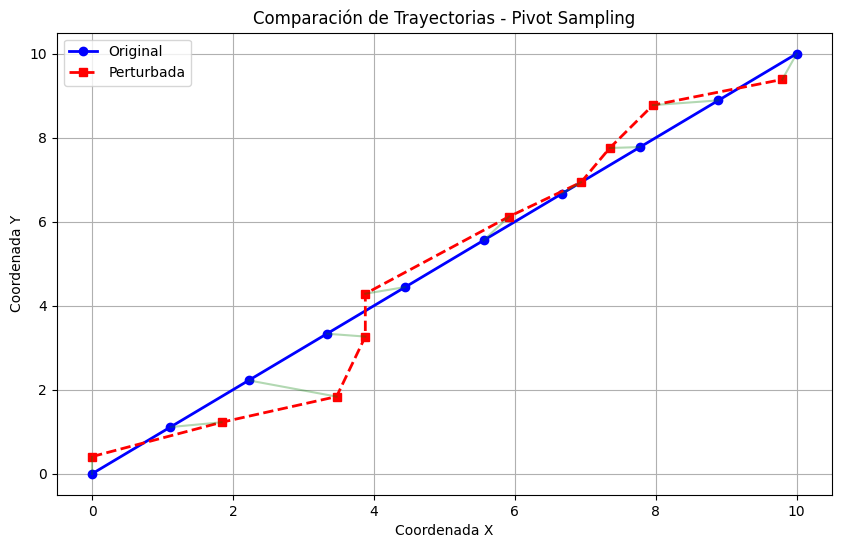

Distancia promedio de perturbación: 0.67 unidades


In [34]:
# Crear una trayectoria de ejemplo (línea recta de (0,0) a (10,10))
original_trajectory = [(i, i) for i in np.linspace(0, 10, 10)]

# Crear un dominio espacial discreto (rejilla 50x50)
grid_size = 50
x_coords = np.linspace(0, 10, grid_size)
y_coords = np.linspace(0, 10, grid_size)
domain = [(x, y) for x in x_coords for y in y_coords]

# Inicializar el algoritmo Pivot Sampling
ps = PivotSampling(epsilon=500)

# Aplicar el algoritmo a la trayectoria
perturbed_trajectory = ps.perturb_trajectory(original_trajectory, domain)

# Visualizar resultados
ps.visualize_trajectories(original_trajectory, perturbed_trajectory)

## Grafica dos trayectorias

In [37]:
import folium
from folium import plugins

ruta_archivo = "../GeoLife Trajectories 1.3/Data/000/Trajectory/20081023025304.plt"
original_trajectory = cargar_trayectoria_real(ruta_archivo)
 
# Crear dominio alrededor de la trayectoria (100m de margen)
domain = crear_dominio_espacial(original_trajectory, radio=100.0)
print(len(original_trajectory), "puntos en el dominio")

# Epsilon seleccionado 
# Problema: Un epsilon muy pequeño genera ruido excesivo
# El presupuesto de privacidad se rompe, escalar epsilon (?) se necesita un epsilon proporcional al numero de puntos de la trayectoria
# Discusion respecto a la utilidad al caso de los usos especficos. Estilo wheels, densidad de las trayectorias en rutas, metrica util de utilidad 
# Definir epsilons suficientemente grandes de acuerdo al numero de puntos de la trayectoria, y el tipo de metodo y para que lo quiero usar 
# Experimentos donde voy ajustando el epsilon, parametro de comparacion inicial con el epsilon, que no haya el ruido de que tan larga es la trayectoria 
# Pruebas 
epsilon_seleccionado = 908.0

ps = PivotSampling(epsilon= epsilon_seleccionado)

# Aplicar perturbación
perturbed_trajectory = ps.perturb_trajectory(original_trajectory, domain)

# Crear un mapa centrado en el primer punto de la trayectoria original
map_center = original_trajectory[0]
m = folium.Map(location=map_center, zoom_start=16)

# Agregar la trayectoria original (azul)
folium.PolyLine(
    locations=original_trajectory,
    color='blue',
    weight=3,
    opacity=0.7,
    tooltip='Original'
).add_to(m)

# Agregar la trayectoria perturbada (rojo)
folium.PolyLine(
    locations=perturbed_trajectory,
    color='red',
    weight=3,
    opacity=0.7,
    tooltip='Perturbada'
).add_to(m)

# Conectar puntos originales con perturbados 
for orig, pert in zip(original_trajectory, perturbed_trajectory):
    folium.PolyLine(
        locations=[orig, pert],
        color='green',
        weight=1,
        opacity=0.3
    ).add_to(m)


folium.Marker(location=original_trajectory[0], popup="Inicio Original", icon=folium.Icon(color='blue')).add_to(m)
folium.Marker(location=perturbed_trajectory[0], popup="Inicio Perturbada", icon=folium.Icon(color='red')).add_to(m)

# Mostrar mapa
m.save("Pivot_graphs/trayectoria_pivot_mapa_nuevaa.html")

distancias = [ps.haversine_distance(orig, pert) 
              for orig, pert in zip(original_trajectory, perturbed_trajectory)]

distancia_media = sum(distancias) / len(distancias)
print(f"Distancia media de perturbación: {distancia_media:.2f} metros")


908 puntos en el dominio
Distancia media de perturbación: 137.77 metros


## Poblar Base de datos

In [5]:
import time
import math
import numpy as np
import pandas as pd
from typing import List, Tuple
from scipy.spatial.distance import directed_hausdorff

# ---- TIPOS ----
Point = Tuple[float, float]
Trajectory = List[Point]

# ---- MÉTRICAS ----
def haversine_distance(p1: Point, p2: Point) -> float:
    R = 6371000.0
    lat1, lon1 = math.radians(p1[0]), math.radians(p1[1])
    lat2, lon2 = math.radians(p2[0]), math.radians(p2[1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

def trajectory_length(traj: Trajectory) -> float:
    return sum(haversine_distance(traj[i], traj[i+1]) for i in range(len(traj)-1))

def mean_displacement(original: Trajectory, perturbed: Trajectory) -> float:
    return np.mean([haversine_distance(o, p) for o, p in zip(original, perturbed)])

def max_displacement(original: Trajectory, perturbed: Trajectory) -> float:
    return np.max([haversine_distance(o, p) for o, p in zip(original, perturbed)])

def std_displacement(original: Trajectory, perturbed: Trajectory) -> float:
    return np.std([haversine_distance(o, p) for o, p in zip(original, perturbed)])

def trajectory_length_error(original: Trajectory, perturbed: Trajectory) -> float:
    return abs(trajectory_length(original) - trajectory_length(perturbed))

def mean_direction_error(original: Trajectory, perturbed: Trajectory) -> float:
    def bearing(p1: Point, p2: Point) -> float:
        lat1, lon1 = math.radians(p1[0]), math.radians(p1[1])
        lat2, lon2 = math.radians(p2[0]), math.radians(p2[1])
        dlon = lon2 - lon1
        y = math.sin(dlon) * math.cos(lat2)
        x = math.cos(lat1)*math.sin(lat2) - math.sin(lat1)*math.cos(lat2)*math.cos(dlon)
        return math.atan2(y, x)
    
    errors = []
    for i in range(len(original)-1):
        theta_orig = bearing(original[i], original[i+1])
        theta_pert = bearing(perturbed[i], perturbed[i+1])
        errors.append(abs(theta_orig - theta_pert))
    return np.mean(errors)

def hausdorff_distance(original: Trajectory, perturbed: Trajectory) -> float:
    a = np.array(original)
    b = np.array(perturbed)
    return max(directed_hausdorff(a, b)[0], directed_hausdorff(b, a)[0])

# ---- EVALUADOR ----
def evaluate_method(method_name: str, original: Trajectory, perturbed: Trajectory, runtime: float, epsilon: float) -> dict:
    return {
        "Método": method_name,
        "Tamaño Trayectoria": len(original),
        "Epsilon": epsilon,
        "Distancia Media (m)": mean_displacement(original, perturbed),
        "Distancia Máx (m)": max_displacement(original, perturbed),
        "Desv. Estándar (m)": std_displacement(original, perturbed),
        "Error Longitud (m)": trajectory_length_error(original, perturbed),
        "Error Dirección (rad)": mean_direction_error(original, perturbed),
        "Hausdorff (m)": hausdorff_distance(original, perturbed),
        "Tiempo (s)": runtime
    }
def get_selected_indices(traj_length: int) -> List[int]:
    step = traj_length // 5  # tamaño de cada tramo
    indices = []
    
    for i in range(1, 6):  # 1 a 5 (porque no queremos incluir 0)
        end_point = i * step
        if end_point <= traj_length:
            indices.append(end_point)
        
        mid_point = (i * step) - (step // 2)
        if mid_point > 0 and mid_point < traj_length:
            indices.append(mid_point)
    
    return sorted(set(indices))

# ---- CARGAR DATOS ----
ruta_archivo = "../GeoLife Trajectories 1.3/Data/000/Trajectory/20081023025304.plt"
original_trajectory = cargar_trayectoria_real(ruta_archivo)
domain = crear_dominio_espacial(original_trajectory, radio=100.0)

# ---- EJECUTAR PRUEBAS (10 corridas por epsilon) ----
max_epsilon = 5 * len(original_trajectory)
epsilons = get_selected_indices(len(original_trajectory)*5)
results = []
N_RUNS = 10

for epsilon in epsilons:
    for run in range(N_RUNS):
        ps = PivotSampling(epsilon=epsilon)
        
        start_time = time.time()
        perturbed_trajectory = ps.perturb_trajectory(original_trajectory, domain)
        runtime = time.time() - start_time
        
        result = evaluate_method("PivotSampling", original_trajectory, perturbed_trajectory, runtime, epsilon)
        result["Run"] = run  # Guardar el número de corrida
        results.append(result)
        print(f"Epsilon: {epsilon}, Run: {run+1}/{N_RUNS} completado.")


# ---- GUARDAR RESULTADOS ----
df_results = pd.DataFrame(results)
print(df_results)

df_results.to_csv("pivot_data_1.csv", index=False)


Epsilon: 454, Run: 1/10 completado.
Epsilon: 454, Run: 2/10 completado.
Epsilon: 454, Run: 3/10 completado.
Epsilon: 454, Run: 4/10 completado.
Epsilon: 454, Run: 5/10 completado.
Epsilon: 454, Run: 6/10 completado.
Epsilon: 454, Run: 7/10 completado.
Epsilon: 454, Run: 8/10 completado.
Epsilon: 454, Run: 9/10 completado.
Epsilon: 454, Run: 10/10 completado.
Epsilon: 908, Run: 1/10 completado.
Epsilon: 908, Run: 2/10 completado.
Epsilon: 908, Run: 3/10 completado.
Epsilon: 908, Run: 4/10 completado.
Epsilon: 908, Run: 5/10 completado.
Epsilon: 908, Run: 6/10 completado.
Epsilon: 908, Run: 7/10 completado.
Epsilon: 908, Run: 8/10 completado.
Epsilon: 908, Run: 9/10 completado.
Epsilon: 908, Run: 10/10 completado.
Epsilon: 1362, Run: 1/10 completado.
Epsilon: 1362, Run: 2/10 completado.
Epsilon: 1362, Run: 3/10 completado.
Epsilon: 1362, Run: 4/10 completado.
Epsilon: 1362, Run: 5/10 completado.
Epsilon: 1362, Run: 6/10 completado.
Epsilon: 1362, Run: 7/10 completado.
Epsilon: 1362, Run:

## Grafica base de datos


📌 Gráfica de Distancia Media (m)
Descripción: Promedio de la distancia entre trayectorias originales y aproximadas.



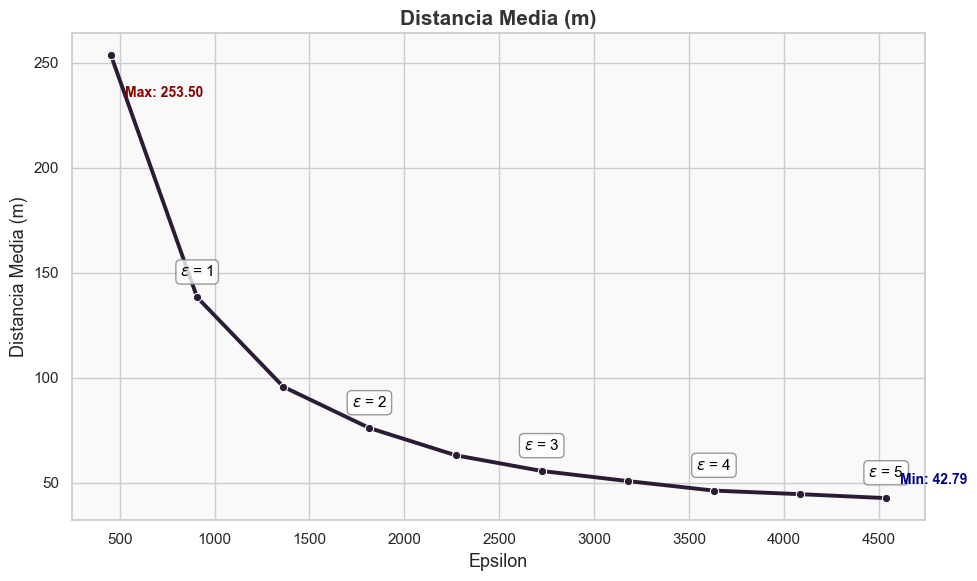


📌 Gráfica de Distancia Máx (m)
Descripción: Mayor distancia registrada entre dos trayectorias.



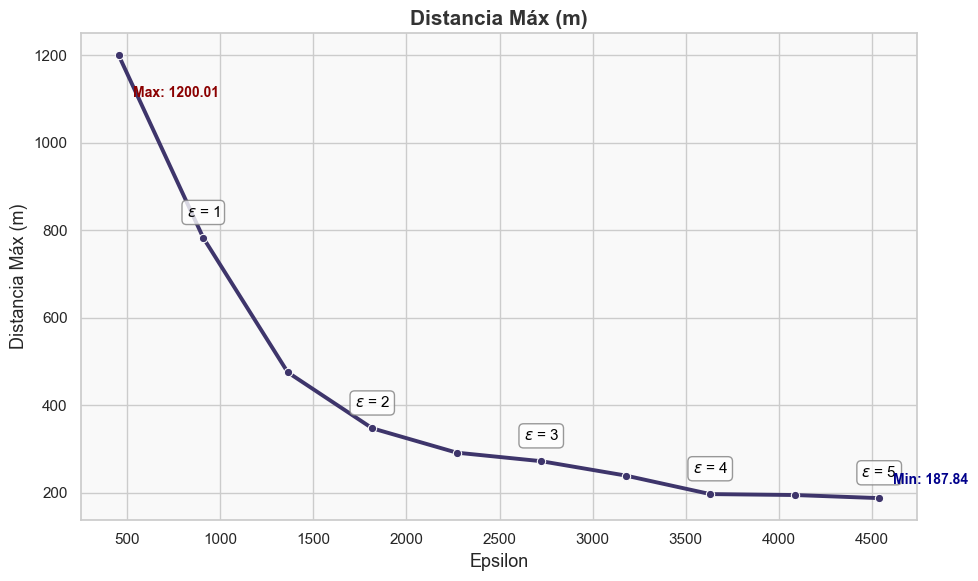


📌 Gráfica de Desv. Estándar (m)
Descripción: Variabilidad de la distancia entre las trayectorias.



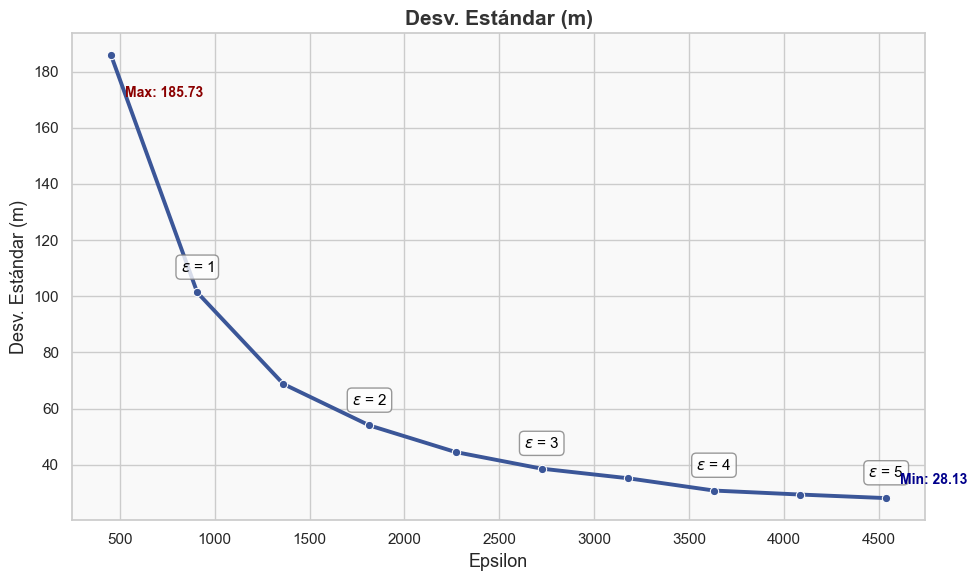


📌 Gráfica de Error Longitud (m)
Descripción: Diferencia en longitud total entre las trayectorias.



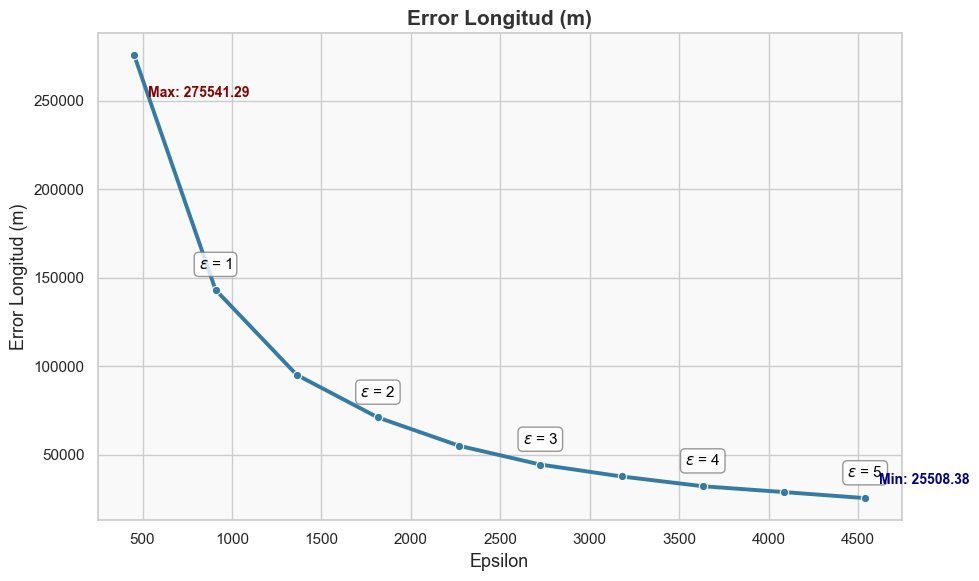


📌 Gráfica de Error Dirección (rad)
Descripción: Diferencia en orientación promedio entre las trayectorias.



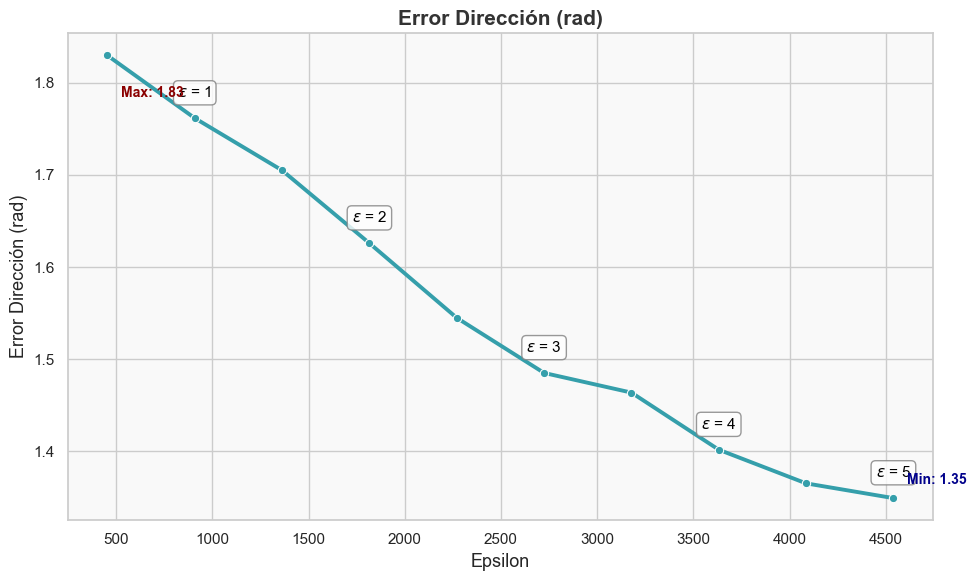


📌 Gráfica de Hausdorff (m)
Descripción: Distancia Hausdorff que mide la similitud entre trayectorias.



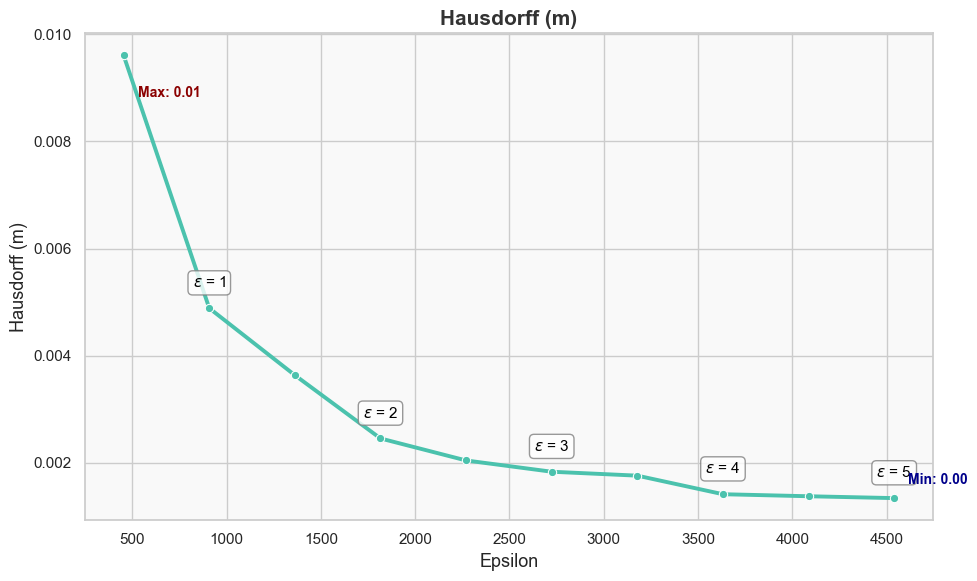


📌 Gráfica de Tiempo (s)
Descripción: Tiempo requerido para el procesamiento.



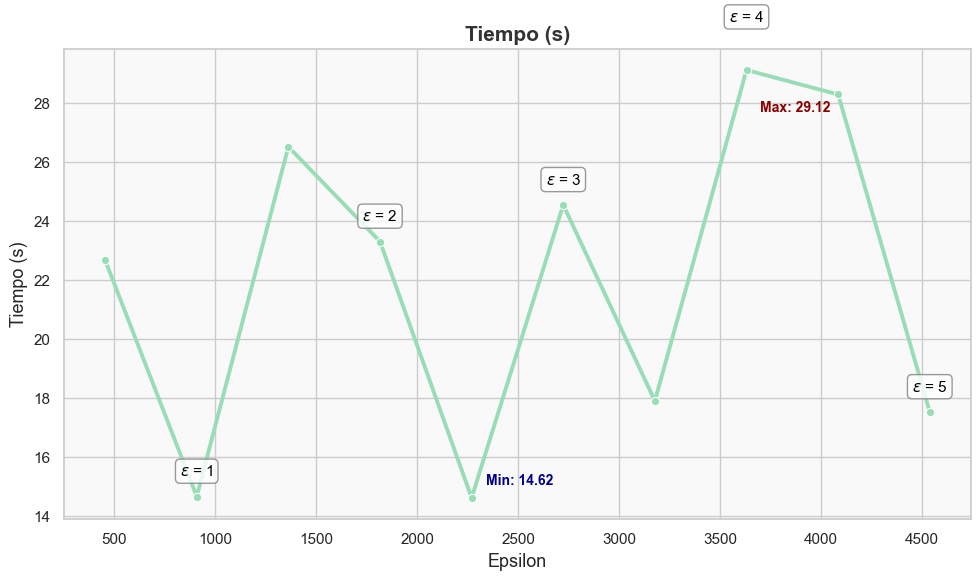

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leer datos
df = pd.read_csv("pivot_data_1.csv")

# Agrupar por epsilon y promediar todas las métricas
df_avg = df.groupby("Epsilon", as_index=False).mean(numeric_only=True)

metricas = [
    "Distancia Media (m)",
    "Distancia Máx (m)",
    "Desv. Estándar (m)",
    "Error Longitud (m)",
    "Error Dirección (rad)",
    "Hausdorff (m)",
    "Tiempo (s)"
]

# Descripciones para cada métrica
descripciones = {
    "Distancia Media (m)": "Promedio de la distancia entre trayectorias originales y aproximadas.",
    "Distancia Máx (m)": "Mayor distancia registrada entre dos trayectorias.",
    "Desv. Estándar (m)": "Variabilidad de la distancia entre las trayectorias.",
    "Error Longitud (m)": "Diferencia en longitud total entre las trayectorias.",
    "Error Dirección (rad)": "Diferencia en orientación promedio entre las trayectorias.",
    "Hausdorff (m)": "Distancia Hausdorff que mide la similitud entre trayectorias.",
    "Tiempo (s)": "Tiempo requerido para el procesamiento."
}

sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 13})

palette = sns.color_palette("mako", len(metricas))

# Índices y etiquetas para epsilon
annot_indices = [1, 3, 5, 7, 9]
epsilons_labels = [r'$\epsilon$ = 1', r'$\epsilon$ = 2', r'$\epsilon$ = 3', r'$\epsilon$ = 4', r'$\epsilon$ = 5']

for i, metrica in enumerate(metricas):
    print(f"\n📌 Gráfica de {metrica}")
    print(f"Descripción: {descripciones[metrica]}\n")
    
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=df_avg, x="Epsilon", y=metrica, marker="o", linewidth=2.8, color=palette[i])
    
    ax.set_title(metrica, fontsize=15, fontweight="bold", color="#333333")
    ax.set_xlabel("Epsilon", fontsize=13)
    ax.set_ylabel(metrica, fontsize=13)
    ax.set_facecolor("#f9f9f9")
    
    # Mostrar números completos en el eje Y
    ax.ticklabel_format(style='plain', axis='y')
    
    # Anotaciones de epsilon (solo si hay suficientes puntos)
    for idx, label in zip(annot_indices, epsilons_labels):
        if idx < len(df_avg):
            x = df_avg["Epsilon"].iloc[idx]
            y = df_avg[metrica].iloc[idx]
            offset_y = 15
            if y == df_avg[metrica].max():
                offset_y += 20
            
            ax.annotate(label,
                        xy=(x, y),
                        xytext=(0, offset_y),
                        textcoords="offset points",
                        ha="center",
                        fontsize=11,
                        color="black",
                        bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.8))
    
    # Anotaciones de máximo y mínimo
    max_val = df_avg[metrica].max()
    min_val = df_avg[metrica].min()
    max_idx = df_avg[metrica].idxmax()
    min_idx = df_avg[metrica].idxmin()
    
    ax.annotate(f"Max: {max_val:.2f}", xy=(df_avg["Epsilon"][max_idx], max_val),
                xytext=(10, -30), textcoords="offset points",
                fontsize=10, color="darkred", fontweight="bold")
    
    ax.annotate(f"Min: {min_val:.2f}", xy=(df_avg["Epsilon"][min_idx], min_val),
                xytext=(10, 10), textcoords="offset points",
                fontsize=10, color="darkblue", fontweight="bold")
    
    plt.tight_layout()
    plt.show()


In [1]:
paso_m = 2000

In [ ]:
import numpy as np
import os
from glob import glob
import math
from collections import defaultdict
from scipy.sparse import dok_matrix

# ----------------- Funciones auxiliares -----------------
def cargar_trayectoria_real(ruta_archivo):
    """Carga trayectoria desde archivo PLT de GeoLife"""
    latlons = []
    with open(ruta_archivo, "r", encoding="utf-8", errors="ignore") as f:
        for i, linea in enumerate(f):
            if i < 6: continue  # Saltar cabecera
            partes = linea.strip().split(",")
            try:
                latlons.append((float(partes[0]), float(partes[1])))
            except (ValueError, IndexError):
                continue
    return latlons

def latlon_a_celda(lat, lon, lat_min, lon_min, paso_m):
    """Convierte lat/lon a índice de celda"""
    paso_lat = paso_m / 111000
    paso_lon = paso_m / (111000 * np.cos(np.radians((lat_min + lat.max())/2)))
    i = ((lat - lat_min) // paso_lat).astype(int)
    j = ((lon - lon_min) // paso_lon).astype(int)
    return i, j

def obtener_celdas_unificadas(trayectorias, trayectorias_pert, paso_m):
    """Obtiene un diccionario con las celdas únicas"""
    todas_lats = np.concatenate([np.array(tray)[:,0] for tray in trayectorias + trayectorias_pert])
    todas_lons = np.concatenate([np.array(tray)[:,1] for tray in trayectorias + trayectorias_pert])
    lat_min, lon_min = todas_lats.min(), todas_lons.min()

    celdas = {}
    idx = 0
    for tray in trayectorias + trayectorias_pert:
        i, j = latlon_a_celda(np.array(tray)[:,0], np.array(tray)[:,1], lat_min, lon_min, paso_m)
        for c in zip(i, j):
            if c not in celdas:
                celdas[c] = idx
                idx += 1
    return celdas, lat_min, lon_min

def construir_matriz_od_sparse(trayectorias, celdas, lat_min, lon_min, paso_m):
    """Construye matriz OD dispersa"""
    n = len(celdas)
    OD = dok_matrix((n, n), dtype=int)
    for tray in trayectorias:
        i, j = latlon_a_celda(np.array(tray)[:,0], np.array(tray)[:,1], lat_min, lon_min, paso_m)
        origen = celdas[(i[0], j[0])]
        destino = celdas[(i[-1], j[-1])]
        OD[origen, destino] += 1
    return OD


# ----------------- Importar Pivot Sampling -----------------
# Asumo que ya tienes tu clase PivotSampling definida
# from pivot_sampling_module import PivotSampling

# ----------------- Cargar trayectorias -----------------
ruta_carpeta = "../GeoLife Trajectories 1.3/Data/002/Trajectory"
archivos_plt = glob(os.path.join(ruta_carpeta, "*.plt"))
trayectorias = [cargar_trayectoria_real(f) for f in archivos_plt]


# ----------------- Aplicar Pivot Sampling -----------------

trayectorias_pert = []
for tray in trayectorias:
    # Elegir un epsilon proporcional a la cantidad de puntos
    epsilon = len(tray) * 5  # Ajusta el factor según tu experimento
    pivot_sampler = PivotSampling(epsilon=epsilon)
  
    # Crear dominio alrededor de la trayectoria
    domain = crear_dominio_espacial(tray, radio=100.0)
    
    # Perturbar la trayectoria
    tray_pert = pivot_sampler.perturb_trajectory(tray, domain)
    trayectorias_pert.append(tray_pert)

# ----------------- Construir celdas y matrices OD -----------------
celdas_unificadas, lat_min, lon_min = obtener_celdas_unificadas(trayectorias, trayectorias_pert, paso_m)
OD_original = construir_matriz_od_sparse(trayectorias, celdas_unificadas, lat_min, lon_min, paso_m)
OD_perturbada = construir_matriz_od_sparse(trayectorias_pert, celdas_unificadas, lat_min, lon_min, paso_m)

# ----------------- Información -----------------
print("Número de celdas:", len(celdas_unificadas))
print("Viajes totales originales:", OD_original.sum())
print("Viajes totales perturbados Pivot Sampling:", OD_perturbada.sum())


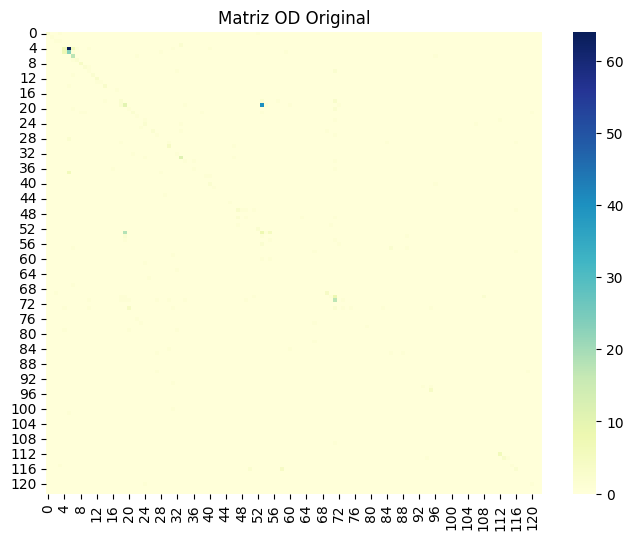

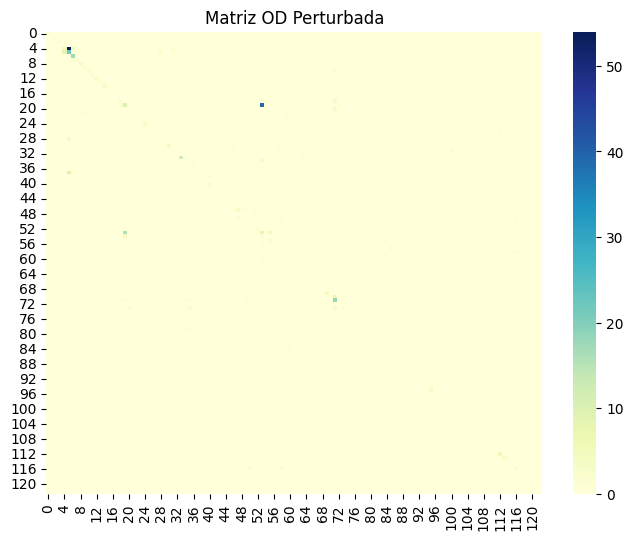

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir a denso solo si no es muy grande
OD_orig_dense = OD_original.todense()
OD_pert_dense = OD_perturbada.todense()

# Heatmap de ejemplo
plt.figure(figsize=(8,6))
sns.heatmap(OD_orig_dense, cmap="YlGnBu", cbar=True)
plt.title("Matriz OD Original")
plt.show()

# Heatmap de ejemplo
plt.figure(figsize=(8,6))
sns.heatmap(OD_pert_dense, cmap="YlGnBu", cbar=True)
plt.title("Matriz OD Perturbada")
plt.show()

In [12]:
import folium
from folium import plugins
from branca.colormap import LinearColormap
import numpy as np
import matplotlib.pyplot as plt



def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# Cantidad de viajes por celda
viajes_por_celda = np.array([OD_original[i,i] for i in range(len(celdas_unificadas))])

# Crear mapa
lat_centro = np.mean([lat_min, np.max(np.concatenate([np.array(tray)[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([np.array(tray)[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# Crear colormap usando matplotlib 'plasma'
colormap = LinearColormap(
    colors=[plt.cm.plasma(i/255)[:3] for i in range(0,256,5)],  # colores del 0 al 255
    vmin=0,
    vmax=viajes_por_celda.max()
)
colormap.caption = "Número de viajes por celda"
colormap.add_to(m)

# Dibujar celdas
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))
    
    # Color según número de viajes
    intensidad = viajes_por_celda[idx]
    color_hex = colormap(intensidad)
    
    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.7,
        tooltip=f"Zona: {idx}\nViajes: {viajes_por_celda[idx]}"
    ).add_to(m)

# Guardar mapa
m.save("Pivot_graphs/celdas_beijing_original.html")


In [13]:
import folium
from folium import plugins
from branca.colormap import LinearColormap
import numpy as np
import matplotlib.pyplot as plt



def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# Cantidad de viajes por celda
viajes_por_celda = np.array([OD_perturbada[i,i] for i in range(len(celdas_unificadas))])

# Crear mapa
lat_centro = np.mean([lat_min, np.max(np.concatenate([np.array(tray)[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([np.array(tray)[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# Crear colormap usando matplotlib 'plasma'
colormap = LinearColormap(
    colors=[plt.cm.plasma(i/255)[:3] for i in range(0,256,5)],  # colores del 0 al 255
    vmin=0,
    vmax=viajes_por_celda.max()
)
colormap.caption = "Número de viajes por celda"
colormap.add_to(m)

# Dibujar celdas
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))
    
    # Color según número de viajes
    intensidad = viajes_por_celda[idx]
    color_hex = colormap(intensidad)
    
    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.7,
        tooltip=f"Zona: {idx}\nViajes: {viajes_por_celda[idx]}"
    ).add_to(m)

# Guardar mapa
m.save("Pivot_graphs/celdas_beijing_perturbado.html")
